## Method 1



In [68]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# constants
rho_oil = 875.3
rho_air = 1.204
g = 9.80
nu = 1.827e-5
d = 6.0e-3
precision = 19

# file paths
velocities_file = '/Users/lucaschoi/Documents/GitHub/PHY294-Milikan-Oil-Drop-Experiment/velocities.tsv'
method1_results_file = '/Users/lucaschoi/Documents/GitHub/PHY294-Milikan-Oil-Drop-Experiment/method1.py'

# charges, uncertainties
charges = []
charge_uncs = []
V_unc = 0.05

# read velocities from file
velocities_df = pd.read_csv(velocities_file, sep='\t')

In [69]:
formatting = []
for _, row in velocities_df.iterrows():
    try:
        # Calculate the charge
        V_stop = row['stopping_voltage'] + 35
        v_d = row['v_fall']
        v_d_unc = row['v_fall_unc']
        q = (9 * np.pi * d / V_stop) * np.sqrt((2 * nu**3 * v_d**3) / (g * rho_oil))

        # Calculate the uncertainty in charge
        partial_q_vd = (3 / 2) * (v_d ** (1/2)) / V_stop
        partial_q_V_stop = -(v_d ** (3/2)) / (V_stop ** 2)
        q_unc = np.sqrt((partial_q_vd * v_d_unc) ** 2 + (partial_q_V_stop * V_unc) ** 2)
        charges.append(q)
        charge_uncs.append(q_unc)
        # print(f'q = {q:.10} \pm {q_unc:.10} C')

        filename = f"{row['stopping_voltage']}\_{row['rising_voltage']}.tsv"
        formatting.append((filename, q, q_unc))

    except Exception as e:
        print(f"{e}")
all_e = []


In [92]:
formatting = sorted(formatting, key=lambda x: x[0])

def format_latex_scientific(x, precision=3):

    # Format the number in scientific notation and replace the `e` with LaTeX notation
    formatted_str = f"{x:.{precision}e}"  # Format as scientific notation
    base, exp = formatted_str.split('e')
    return f"{base}e^{{{exp}}}"  # Create LaTeX-style e^exp notation

for filename, q, q_unc in formatting:
    # Format q and q_unc for LaTeX scientific notation
    q_latex = format_latex_scientific(q)
    q_unc_latex = format_latex_scientific(q_unc, 0)
    
    # Print LaTeX formatted output
    print(f"{filename} & ${q_latex} \\pm {q_unc_latex}$ \\\\")

106.9\_205.9.tsv & $2.094e^{-19} \pm 4e^{-11}$ \\
116.9\_207.8.tsv & $1.686e^{-19} \pm 2e^{-11}$ \\
126.8\_280.8.tsv & $2.126e^{-19} \pm 5e^{-11}$ \\
133.2\_228.4.tsv & $1.806e^{-19} \pm 6e^{-11}$ \\
136.1\_222.2.tsv & $1.669e^{-19} \pm 4e^{-11}$ \\
137.4\_146.8.tsv & $7.390e^{-19} \pm 3e^{-11}$ \\
148.1\_217.4.tsv & $8.709e^{-20} \pm 2e^{-11}$ \\
157.4\_227.3.tsv & $9.348e^{-20} \pm 3e^{-11}$ \\
160.8\_237.4.tsv & $1.398e^{-19} \pm 2e^{-11}$ \\
171.8\_297.6.tsv & $1.403e^{-19} \pm 2e^{-11}$ \\
179.9\_227.3.tsv & $1.416e^{-19} \pm 2e^{-11}$ \\
186.3\_227.1.tsv & $1.841e^{-19} \pm 3e^{-11}$ \\
219.4\_324.4.tsv & $1.692e^{-19} \pm 2e^{-11}$ \\
221.9\_359.6.tsv & $1.906e^{-19} \pm 6e^{-11}$ \\
223.4\_358.7.tsv & $1.287e^{-19} \pm 2e^{-11}$ \\
227.4\_267.0.tsv & $1.650e^{-19} \pm 5e^{-12}$ \\
228.1\_300.4.tsv & $1.735e^{-19} \pm 4e^{-11}$ \\
235.7\_336.6.tsv & $1.500e^{-19} \pm 2e^{-11}$ \\
236.0\_437.6.tsv & $2.430e^{-19} \pm 3e^{-11}$ \\
239.9\_356.1.tsv & $1.602e^{-19} \pm 2e^{-11}$ \\


In [71]:

def estimate_elementary_charge(q_list, e_min=1e-19, e_max=2e-19, num_steps=1000000):
    """
    Estimate the elementary charge by trying possible divisors of q_list.
    
    Args:
        q_list (array-like): Measured charges in Coulombs
        e_min, e_max: Range to scan for candidate e
        num_steps: Number of candidate e values to test
    
    Returns:
        best_e: Estimated elementary charge
        scores: List of scores for all candidate e values
    """

    q_array = np.array(q_list)

    # list of possible e values to check
    candidate_es = np.linspace(e_min, e_max, num_steps)
    best_score = float('inf')
    best_e = None
    scores = []

    for e in candidate_es:

        # Divide all q values by e and check how close to nearest integer
        multiples = q_array / e
        residuals = np.abs(multiples - np.round(multiples))

        # Weighted residuals since we have uncertainties
        weighted_residuals = residuals / charge_uncs
        score = np.max(np.abs(weighted_residuals))
        # score = np.mean(residuals)

        scores.append(score)
        all_e.append((e, score))
        
        if score < best_score:
            best_score = score
            best_e = e

    return best_e, scores, candidate_es

In [93]:
print(min(charges), max(charges))

8.708768049810126e-20 1.8704579055058954e-18


In [96]:
e_max = 1e-17
e_min = 1e-21
estimated_e = []
probe_min = e_min
all_e = []

# Step size for incrementing and decrementing
step_size = 5e-20

while probe_min <= e_max:
    probe_max = probe_min + step_size
    print(f"Testing range: e_min = {probe_min:.3e}, e_max = {probe_max:.3e}")
    
    best_e, scores, candidate_es = estimate_elementary_charge(
        charges,
        e_min=probe_min,
        e_max=probe_max,
        num_steps=10000
    )
    
    estimated_e.append((probe_min, probe_max, best_e, scores))
    
    probe_min = probe_max


Testing range: e_min = 1.000e-21, e_max = 5.100e-20
Testing range: e_min = 5.100e-20, e_max = 1.010e-19
Testing range: e_min = 1.010e-19, e_max = 1.510e-19
Testing range: e_min = 1.510e-19, e_max = 2.010e-19
Testing range: e_min = 2.010e-19, e_max = 2.510e-19
Testing range: e_min = 2.510e-19, e_max = 3.010e-19
Testing range: e_min = 3.010e-19, e_max = 3.510e-19
Testing range: e_min = 3.510e-19, e_max = 4.010e-19
Testing range: e_min = 4.010e-19, e_max = 4.510e-19
Testing range: e_min = 4.510e-19, e_max = 5.010e-19
Testing range: e_min = 5.010e-19, e_max = 5.510e-19
Testing range: e_min = 5.510e-19, e_max = 6.010e-19
Testing range: e_min = 6.010e-19, e_max = 6.510e-19
Testing range: e_min = 6.510e-19, e_max = 7.010e-19
Testing range: e_min = 7.010e-19, e_max = 7.510e-19
Testing range: e_min = 7.510e-19, e_max = 8.010e-19
Testing range: e_min = 8.010e-19, e_max = 8.510e-19
Testing range: e_min = 8.510e-19, e_max = 9.010e-19
Testing range: e_min = 9.010e-19, e_max = 9.510e-19
Testing rang

In [97]:
# sort the all_e's by the best score
all_e.sort(key=lambda x: x[1])

for i in range(100):
    print(f"Best e = {all_e[i][0]:.6e} C with score {all_e[i][1]}")

# average of best 10 ** n
for i in range(6):

    scale = 10 ** i
    if scale > len(all_e):
        break
    print(f"Average of best {scale} = {np.mean([all_e[i][0] for i in range(scale)]):.3e} C")

print(max(all_e[:100], key=lambda x: x[0]))




Best e = 1.000100e-17 C with score 4233169087.6529856
Best e = 1.000099e-17 C with score 4233171204.2386093
Best e = 1.000099e-17 C with score 4233173320.8263493
Best e = 1.000098e-17 C with score 4233175437.416206
Best e = 1.000098e-17 C with score 4233177554.0081787
Best e = 1.000097e-17 C with score 4233179670.602268
Best e = 1.000097e-17 C with score 4233181787.1984754
Best e = 1.000096e-17 C with score 4233183903.7967978
Best e = 1.000096e-17 C with score 4233186020.3972373
Best e = 1.000095e-17 C with score 4233188136.999793
Best e = 1.000095e-17 C with score 4233190253.604466
Best e = 1.000094e-17 C with score 4233192370.211255
Best e = 1.000094e-17 C with score 4233194486.820161
Best e = 1.000093e-17 C with score 4233196603.431184
Best e = 1.000093e-17 C with score 4233198720.0443225
Best e = 1.000092e-17 C with score 4233200836.659579
Best e = 1.000092e-17 C with score 4233202953.2769504
Best e = 1.000091e-17 C with score 4233205069.89644
Best e = 1.000091e-17 C with score 423

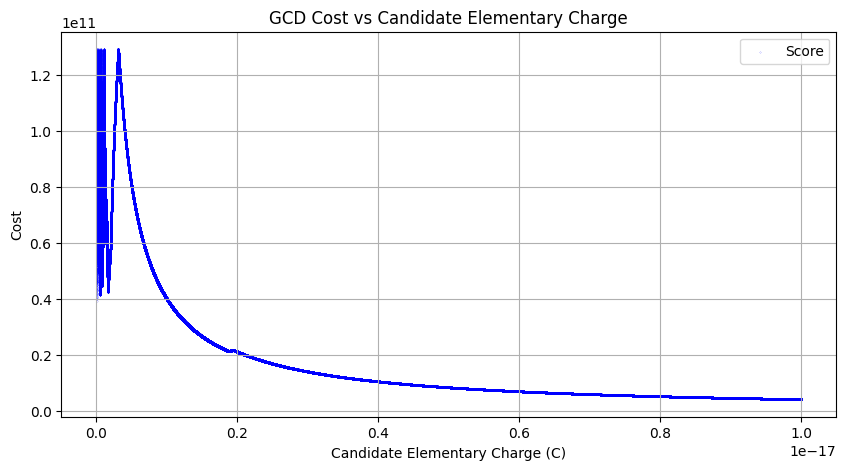

In [98]:
# Unpack all_e
# all_e = sorted(all_e, key=lambda x: x[1])
candidate_es, scores = zip(*all_e)



# Plot
plt.figure(figsize=(10, 5))
plt.scatter(candidate_es, scores, label='Score', color='blue', s=0.01)
plt.xlabel("Candidate Elementary Charge (C)")
plt.ylabel("Cost")
plt.title("GCD Cost vs Candidate Elementary Charge")
plt.grid(True)
plt.legend()

plt.show()


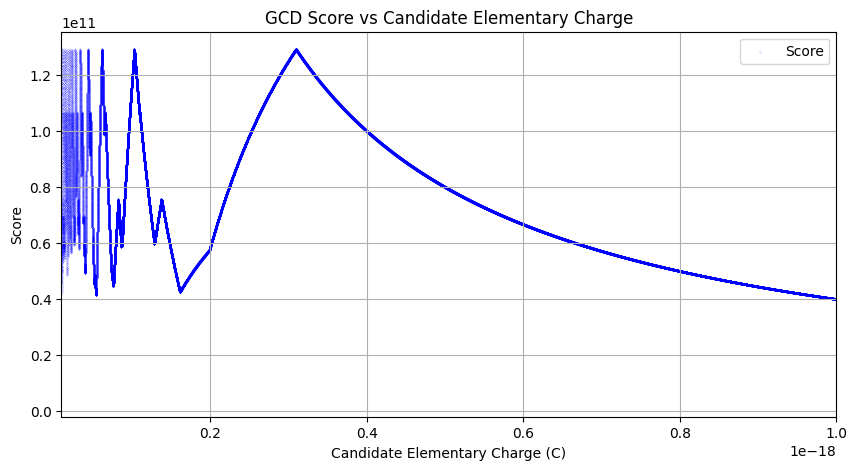

In [ ]:


# Plot
plt.figure(figsize=(10, 5))
plt.scatter(candidate_es, scores, label='Score', color='blue', s=0.01)
plt.xlabel("Candidate Elementary Charge (C)")
plt.ylabel("Cost")
plt.xlim(.1e-19, 1e-18)
plt.title("GCD Cost vs Candidate Elementary Charge")
plt.grid(True)
plt.legend()

plt.show()

In [119]:
# print top 2 lowest scores between .5e-19 and 2.2e-19
top_scores = sorted(all_e, key=lambda x: x[1])
top_scores = [x for x in top_scores if .6e-19 < x[0] < 2.2e-19]
for e, score in top_scores[:400]:
    print(e, score)


avg = np.mean([x[0] for x in top_scores[:200]])
print(f"Average of top 200 scores = {avg:.6e} C")

std_dev = np.std([x[0] for x in top_scores[:50000]])
print(f"Standard deviation of top 50000 scores = {std_dev:.6e} C")

1.6145104510451045e-19 42551694107.50657
1.6145604560456046e-19 42554121170.31682
1.6146104610461046e-19 42556548082.79325
1.6144604460446044e-19 42556595020.85367
1.6146604660466047e-19 42558974844.94984
1.6147104710471048e-19 42561401456.80054
1.6144104410441044e-19 42562591088.85328
1.6147604760476048e-19 42563827918.35932
1.6148104810481049e-19 42566254229.64014
1.6143604360436043e-19 42568587528.31072
1.614860486048605e-19 42568680390.65696
1.614910491049105e-19 42571106401.42374
1.614960496049605e-19 42573532261.95443
1.6143104310431043e-19 42574584339.26046
1.615010501050105e-19 42575957972.26301
1.6150605060506052e-19 42578383532.3634
1.6142604260426044e-19 42580581521.73701
1.6151105110511052e-19 42580808942.26958
1.6151605160516053e-19 42583234201.99547
1.6152105210521054e-19 42585659311.555046
1.6142104210421044e-19 42586579075.77496
1.6152605260526054e-19 42588084270.96224
1.6153105310531052e-19 42590509080.23099
1.6141604160416043e-19 42592577001.40878
1.6153605360536053e-

In [78]:
N = 30  # You can change this to 10, 50, etc.

# Zip scores and candidate_es, then sort by score (ascending)
sorted_e = sorted(zip(scores, candidate_es))[:N]  # Take top N by score

# Extract the e values only
top_es = [e for _, e in sorted_e]

# Compute mean and standard deviation
mean_e = np.mean(top_es)
std_e = np.std(top_es)


mean_q_unc = np.mean(charge_uncs)  # in C
mean_n = np.mean([q / mean_e for q in charges])  # approx electron count per drop

propagated_e_unc = mean_q_unc / mean_n  # rough propagation

combined_unc = np.sqrt(std_e**2 + propagated_e_unc**2)

print(f"Final e = {mean_e:.3e} ± {combined_unc:.1e} C")
print(4/3 * 4.5 **(3/2))


Final e = 9.345e-19 ± 7.3e-11 C
12.727922061357855


In [79]:
for i in range(51):
    print(charges[i], charge_uncs[i])

1.2699837852130204e-19 3.573539178175211e-11
1.9540009044501294e-19 1.077478025033109e-11
1.735034788423441e-19 3.573795541831217e-11
2.0937507892715873e-19 3.5223345655516144e-11
1.8061754254631597e-19 6.427908735764053e-11
1.5485899794220705e-19 3.874977741303575e-12
4.652566576131881e-19 1.4569502439320084e-11
1.8073240161991075e-19 2.1069116813043212e-11
1.6689008862092483e-19 3.5027675839770304e-11
1.7277733646881906e-19 7.193709482128276e-12
1.4831050415994398e-19 8.304178238592114e-12
1.6739363093798036e-19 2.36669370777026e-11
1.3170694548613867e-19 1.0287600114955875e-11
2.0759100060867648e-19 3.120944029770048e-11
1.3849432002057519e-19 2.0142161861361064e-11
2.1258050887108836e-19 5.1841354180711336e-11
3.7555047376110636e-19 1.57485685016383e-11
1.594471355988662e-19 1.7078765220463882e-11
1.0897807979047455e-18 6.518576033289729e-11
1.389526680316659e-19 1.307464066787906e-11
1.2868593905326528e-19 2.3794355041111206e-11
2.0693873097011734e-19 6.621361526602758e-12
8.70876